In [1]:
import pandas as pd
from datetime import datetime
from helper_util import *
import seaborn as sns
from helper_simulation import expand_data_df
current_date = datetime.now().strftime("%Y%m%d")    
pd.set_option('display.max_columns', None)
%matplotlib inline



max_id=get_max("exp_result")
exp_str=""
log_path=f"exp_result/{str(max_id)}.{current_date}.applicationChinaDerivatives"

df_opfuiv=pd.read_parquet("/home/jianj0c/project/STP/dataset/opt_fut_iv_prices.parquet")
meta_info=pd.read_csv("/home/jianj0c/project/STP/dataset/mata_info.csv")

logger=get_logger(log_path)

/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/jianj0c/anaconda3/envs/py3-env/lib/python3.7/site-packages/tigramite/independence_tests/gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


exp_result/142.20250303.applicationChinaDerivatives/xx.log


Parameters 

In [2]:
INTERVAL=600
pc_alpha=0.001
quantile=1

logger.info(f"INTERVAL: {INTERVAL}")
logger.info(f"pc_alpha: {pc_alpha}")
logger.info(f"quantile: {quantile}")



# visualization the data


In [ ]:

df_opfuiv=df_opfuiv.reset_index()
df_opfuiv.tail()

In [ ]:
df_opfuiv["rb_0.fut"].iloc[::100].plot()

Soda ash (SA) is a key industrial chemical used in the manufacturing of glass, chemicals, detergents, and various other products.

In [ ]:
import matplotlib.pyplot as plt

Product_name="ag"
trading_day="20250103"
df=df_opfuiv[df_opfuiv["info.tradingday"]==trading_day]

fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()

df[f"{Product_name}.fut"].iloc[:260000:100].plot(ax=ax1, color='b', label='future')
df[f"{Product_name}.iv"].iloc[:260000:100].plot(ax=ax2, color='r', label='implied volatility (iv)')

ax1.set_title("future price and its implied volatility")
ax1.set_ylabel("future price", color='b')
ax2.set_ylabel("iv", color='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(8, 6))

ax2 = ax1.twinx()

df[f"{Product_name}.fut"].iloc[:260000:100].plot(ax=ax1, color='b', label='future')
df[f"{Product_name}.opt"].iloc[:260000:100].plot(ax=ax2, color='r', label='option price')

ax1.set_title("future price and its option price")
ax1.set_ylabel("future price", color='b')
ax2.set_ylabel("option price", color='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()
meta_info[meta_info["trading_day"]==int(trading_day)][[x  for x in meta_info.columns if  x.startswith(f"{Product_name}_")]]

In [ ]:
import matplotlib.pyplot as plt

Product_name="ag"
trading_day="20240130"
df=df_opfuiv[df_opfuiv["info.tradingday"]==trading_day]





some visualization of the data

To reduce the scale of problem, we groups those product based on \cite{Jiang} and study the dependence (for the change of ) within and cross the groups.

In [3]:
categories={'oil crops': ['a', 'm', 'OI', 'p', 'b', 'RM', 'RS', 'y'],
 'precious metals': ['ag', 'au'],
 'nonferrous metals': ['al', 'bc', 'cu', 'ni', 'pb', 'sn', 'zn','ao'],
 'economic crops': ['AP', 'CF', 'CJ', 'CY', 'PK', 'SR'],
 'rubber&woods': ['bb', 'br', 'fb', 'nr', 'ru', 'sp'],
 'oil&gas': ['bu', 'fu', 'lu', 'pg', 'sc'],
 'grains': ['c', 'cs', 'JR', 'LR', 'PM', 'RI', 'WH','rr'],
 'olefins': ['eb', 'l', 'pp', 'v'],
 'alcohols': ['eg', 'MA'],
 'inorganics': ['FG', 'SA', 'UR', 'SH'],
 'ferrous metals': ['hc', 'i', 'rb', 'SF', 'SM', 'ss', 'wr'],
 'equity index': ['IC', 'IF', 'IH', 'IM'],
 'coals': ['j', 'jm', 'ZC'],
 'animals': ['jd', 'lh'],
 'novel materials': ['lc', 'si'],
 'aromatics': ['PF', 'TA', 'PX'],
 'interest rates': ['T', 'TF', 'TL', 'TS'],
 'indices': ['ec']}

In [4]:
pd.set_option('display.max_rows', None)




price_series=df_opfuiv[[x for x in df_opfuiv.columns if x.endswith("_0.fut")]]
return_df=pd.concat([price_series.pct_change(periods=INTERVAL),df_opfuiv[["info.segment_index"]]],axis=1).iloc[::INTERVAL,].copy()


return_df.loc[~return_df["info.segment_index"].diff().eq(0).fillna(False),[x for x in return_df.columns if not x.startswith("info.")]] = 0

volumes=df_opfuiv[[x for x in df_opfuiv.columns if x.endswith(".volume")]+["info.segment_index","info.tradingday"]].copy()
volumes[[x for x in volumes.columns if x.endswith(".volume")]]=volumes[[x for x in volumes.columns if x.endswith(".volume")]].fillna(0)
volumes[[x for x in volumes.columns if x.endswith(".volume")]]=volumes[[x for x in volumes.columns if x.endswith(".volume")]].cumsum()

daily_volumes = volumes.groupby("info.tradingday").apply(
    lambda x: x[[c for c in x.columns if c.endswith(".volume")]].iloc[-1] - x.iloc[0]
)
incremental=volumes[[x for x in volumes.columns if x.endswith(".volume")]].diff(INTERVAL)
incremental["info.tradingday"]=volumes["info.tradingday"]
incremental=incremental.iloc[::INTERVAL,].copy()
# 计算每个5分钟增量占当日总成交量的比例（考虑交易日非唯一索引的情况）
results=(
    incremental.groupby("info.tradingday", group_keys=False)  # 按交易日分组但保留原始索引
    .apply(lambda x: x[[col for col in x if col.endswith(".volume")]]  # 选择成交量列
           .div(daily_volumes.loc[x.name], axis=1)  # 使用x.name获取当前交易日对应总成交量
           )  # 转换为百分比
    .reset_index()  # 恢复原始索引结构
)
volume_percentage=results.fillna(0)

volume_percentage.set_index("timeindex",inplace=True,drop=True)
df_in_one=pd.concat([volume_percentage[[x for x in volume_percentage.columns if x.endswith(".volume")]],return_df[[x for x in return_df.columns if  x.endswith(".fut")]]],axis=1)

In [ ]:




categories_series={}
for category in categories:
    if category=="Grains":
        continue
    print(category)
    asset_list=categories[category]
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in asset_list and x.endswith(".volume")]]
    sub_df=sub_df.loc[:,~(sub_df<0.01).all()]
    if sub_df.shape[1]==0:
        continue
    g=sns.pairplot(sub_df,corner=False)

    save_path=os.path.join(log_path,f"{category}_volume_pairplot.png")
    g.savefig(save_path,dpi=200,  pad_inches=0)

    resultsThisPaper,results_tail=method_this_paper(sub_df,pc_alpha=pc_alpha,quantile=quantile,tau_max=1)


    save_path=os.path.join(log_path,f"{category}_volume_timeseries_graph.png")
    draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,edge_shape=resultsThisPaper,save_path=save_path,var_names=sub_df.columns)
    save_path=os.path.join(log_path,f"{category}_volume_graph.png")
    draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=figsize,edge_shape=resultsThisPaper,save_path=save_path,var_names=sub_df.columns)




In [ ]:
categories_series={}
for category in categories:
    asset_list=categories[category]
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in asset_list and x.endswith(".volume")]]
    sub_df=sub_df.loc[:,~(sub_df<0.01).all()]
    if sub_df.shape[1]==0:
        continue
    categories_series[category]=sub_df.mean(axis=1)

categories_volumes=pd.DataFrame(categories_series)
g=sns.pairplot(categories_volumes,corner=False)


resultsThisPaper,results_tail=method_this_paper(categories_volumes,pc_alpha=pc_alpha,quantile=quantile,tau_max=1)
save_path=os.path.join(log_path,f"sectors_volume_timeseries_graph.png")
draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,var_names=categories_volumes.columns,edge_shape=resultsThisPaper,save_path=save_path)
save_path=os.path.join(log_path,f"sectors_volume_graph.png")
draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(10,10),var_names=categories_volumes.columns,edge_shape=resultsThisPaper,save_path=save_path)

In [ ]:

categories_series={}
for category in categories:
    if category=="Grains":
        continue
    asset_list=categories[category]
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in asset_list and x.endswith(".fut")]]
    g=sns.pairplot(sub_df,corner=False)

    save_path=os.path.join(log_path,f"{category}_fut_pairplot.png")
    g.savefig(save_path,dpi=200,  pad_inches=0)

    data_df_bar=expand_data_df(sub_df)
    resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail_variable=sub_df.shape[1])
    var_names=np.array([f"${i}^{{u}}$" for i in asset_list]+[f"${i}^{{l}}$" for i in asset_list])

    
    if category=="Chemicals":
        figsize=(10,10)
    else:
        figsize=(5,5)
    save_path=os.path.join(log_path,f"{category}_fut_timeseries_graph.png")
    draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
    save_path=os.path.join(log_path,f"{category}_graph.png")
    draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=figsize,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)


categories_series={}
for category in categories:
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in categories[category] and x.endswith(".fut")]]
    categories_series[category]=sub_df.mean(axis=1)
categories_returns=pd.DataFrame(categories_series)
g=sns.pairplot(categories_returns,corner=False)
data_df_bar=expand_data_df(categories_returns)
resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail_variable=categories_returns.shape[1])
var_names=np.array([f"${i}^{{u}}$" for i in categories_returns.columns]+[f"${i}^{{l}}$" for i in categories_returns.columns])
save_path=os.path.join(log_path,f"sectors_fut_timeseries_graph.png")
draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
save_path=os.path.join(log_path,f"sectors_fut_graph.png")
draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(10,10),**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)






price and volume (both tail data and single tail data)

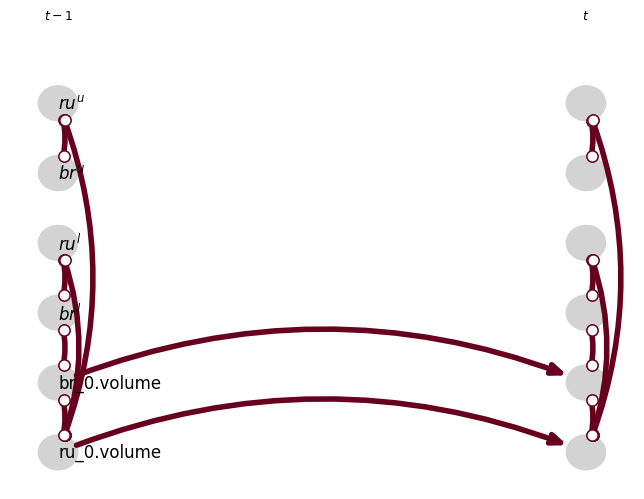

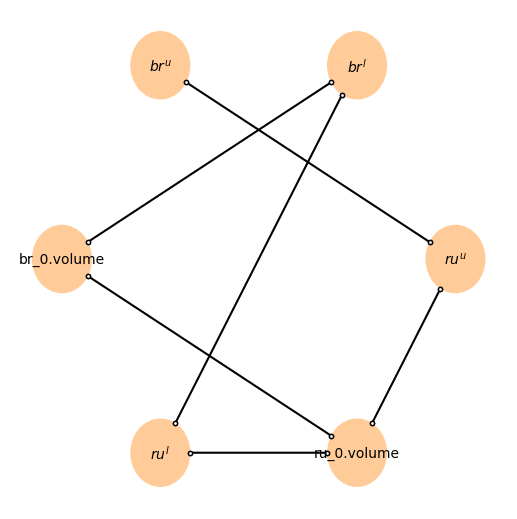

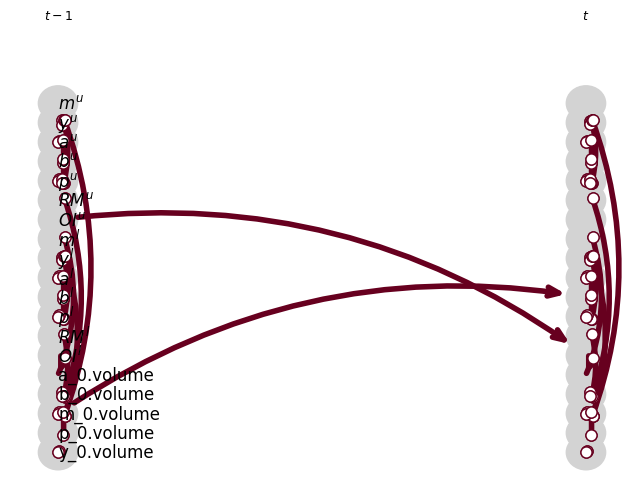

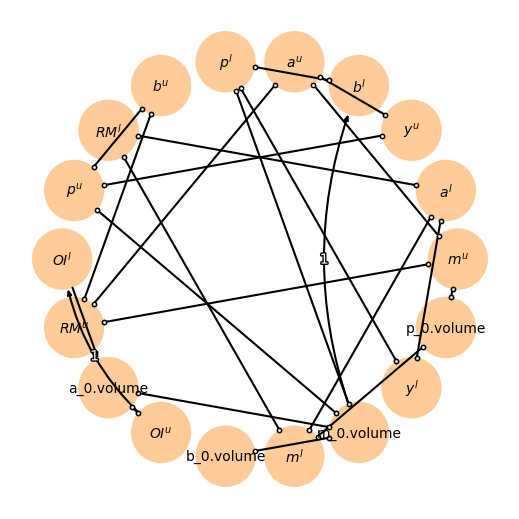

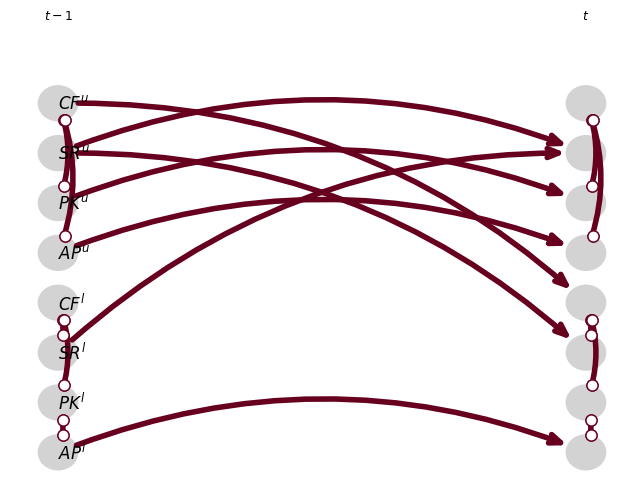

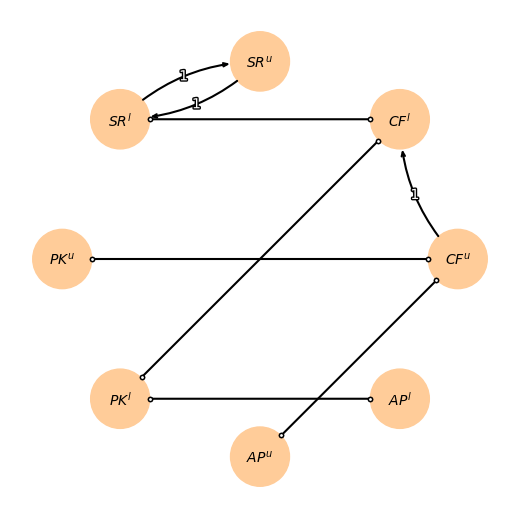

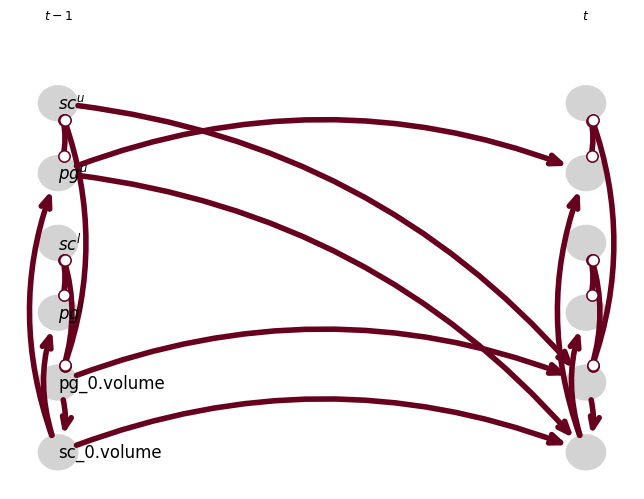

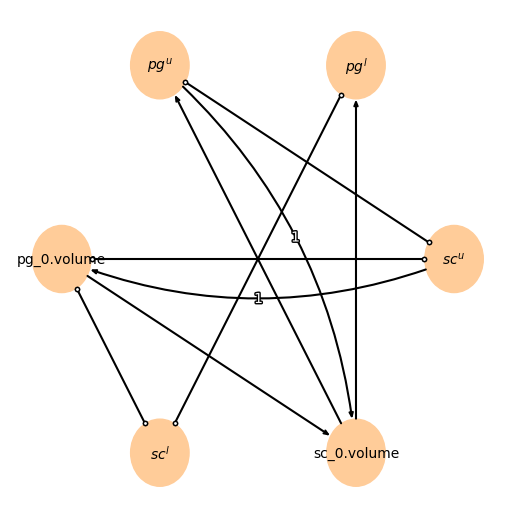

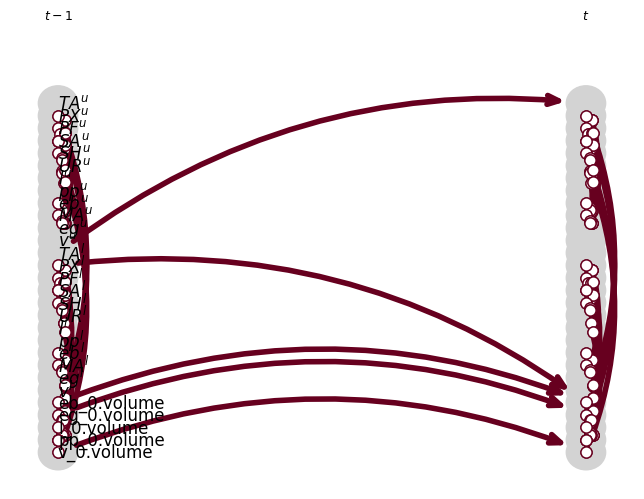

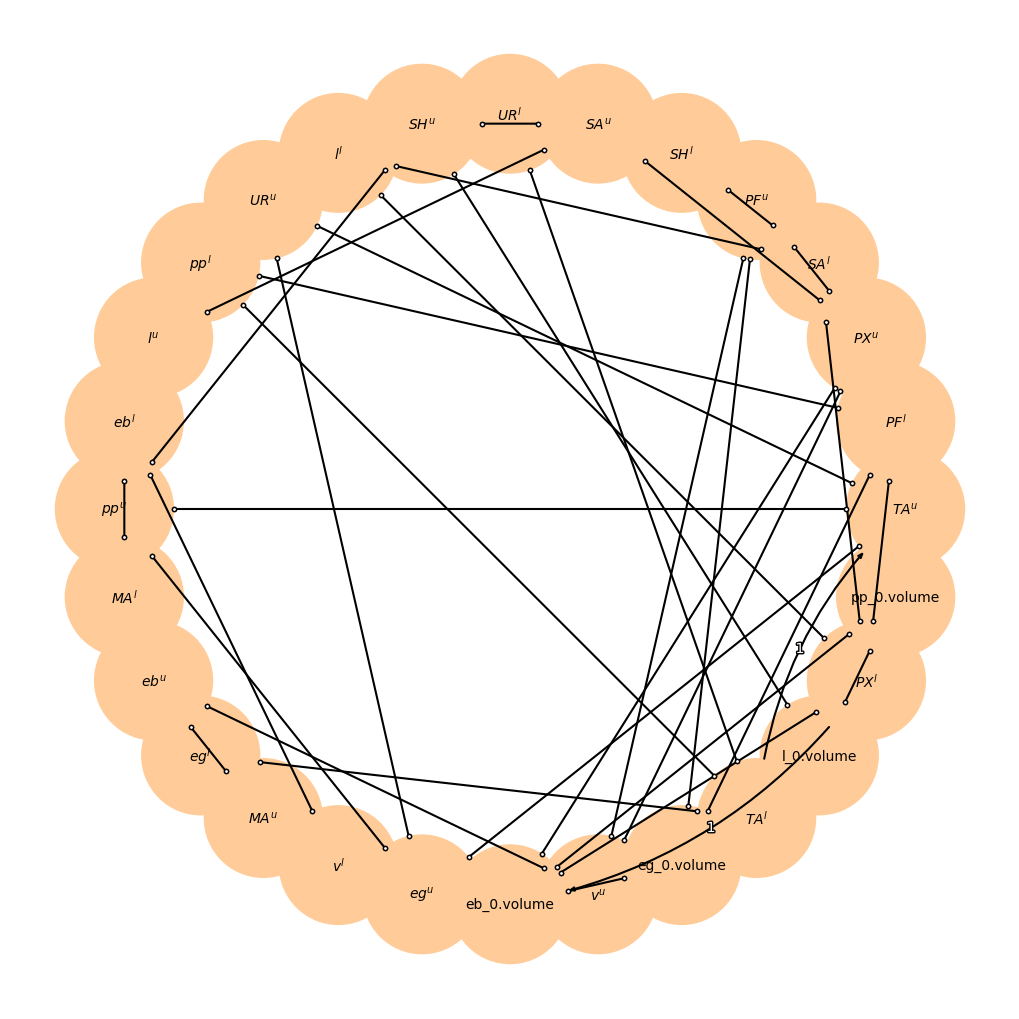

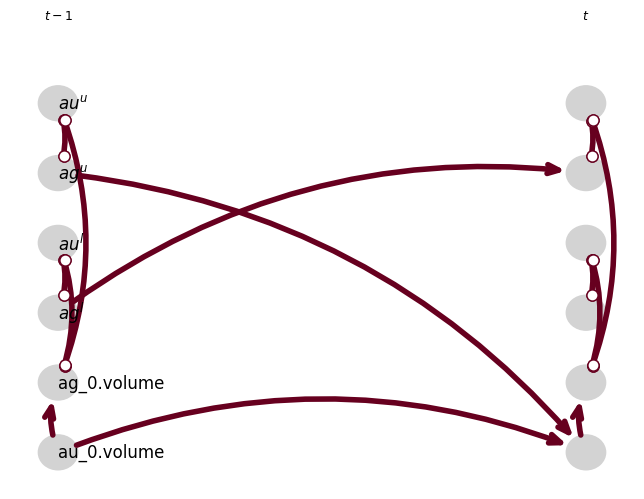

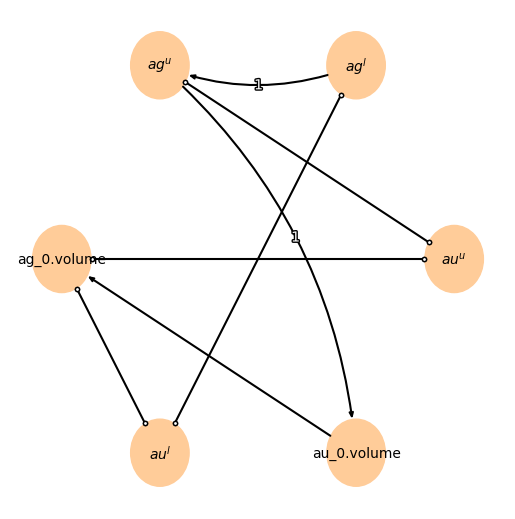

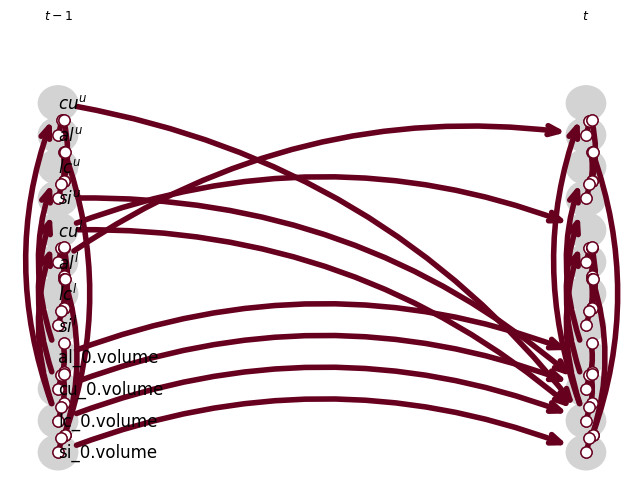

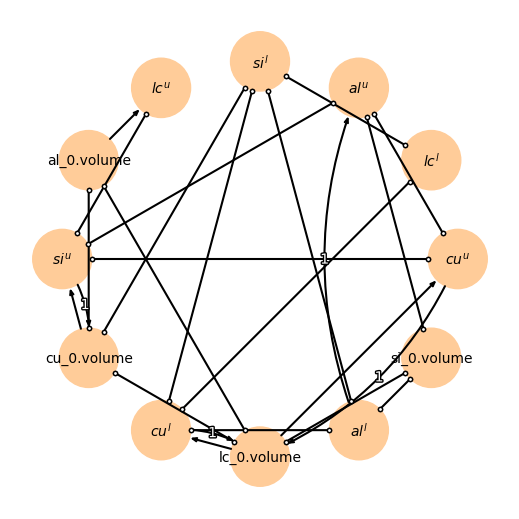

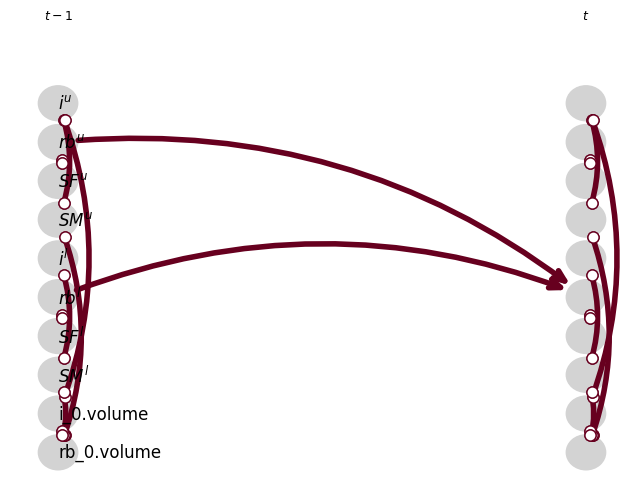

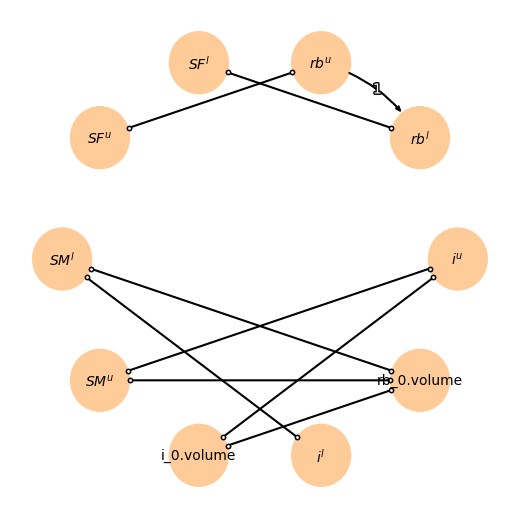

In [16]:

categories_series={}
for category in categories:
    if category=="Grains":
        continue
    asset_list=categories[category]
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in asset_list and x.endswith(".fut")]]


    data_df_bar=expand_data_df(sub_df)


    sub_df_vol=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in asset_list and x.endswith(".volume")]]
    sub_df_vol=sub_df_vol.loc[:,~(sub_df_vol<0.01).all()].reset_index(drop=True)

    data_df_bar_vol=pd.concat([data_df_bar,sub_df_vol],axis=1)

    resultsThisPaper,results_tail=method_this_paper(data_df_bar_vol,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail_variable=sub_df.shape[1])
    var_names=np.array([f"${i}^{{u}}$" for i in asset_list]+[f"${i}^{{l}}$" for i in asset_list]+sub_df_vol.columns.tolist())


    if category=="Chemicals":
        figsize=(10,10)
    else:
        figsize=(5,5)
    save_path=os.path.join(log_path,f"{category}_olut_timeseries_graph.png")

    # xx=sort_name_and_edge(resultsThisPaper,var_names)
    # edge_shape=xx["edge_shape"]
    # var_names=xx["var_names"]
    draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,edge_shape=resultsThisPaper,save_path=save_path,var_names=var_names)
    save_path=os.path.join(log_path,f"{category}_olut_graph.png")
    draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=figsize,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)



In [6]:
resultsThisPaper.shape

(4, 4, 2)

In [ ]:
var_names

In [ ]:

categories_series={}
for category in categories:
    sub_df=df_in_one[[x for x in df_in_one.columns if x.split(".")[0][:-2] in categories[category] and x.endswith(".fut")]]
    categories_series[category]=sub_df.mean(axis=1)
categories_returns=pd.DataFrame(categories_series)
g=sns.pairplot(categories_returns,corner=False)
data_df_bar=expand_data_df(categories_returns)
resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail_variable=categories_returns.shape[1])
var_names=np.array([f"${i}^{{u}}$" for i in categories_returns.columns]+[f"${i}^{{l}}$" for i in categories_returns.columns])
save_path=os.path.join(log_path,f"sectors_fut_timeseries_graph.png")
draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
save_path=os.path.join(log_path,f"sectors_fut_graph.png")
draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(10,10),**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)






In [ ]:


option_iv_change=get_return_from_df(df_opfuiv[[x for x in df_opfuiv.columns if x.endswith(".opt")]+["info.segment_index"]],interval=INTERVAL,subsampling=True)


categories_series={}
for category in categories:
    if category=="Grains":
        continue
    print(category)
    asset_list=categories[category]
    sub_df=option_iv_change[[x for x in option_iv_change.columns if x.split(".")[0] in asset_list]]
    g=sns.pairplot(sub_df,corner=False)

    save_path=os.path.join(log_path,f"{category}_iv_pairplot.png")
    g.savefig(save_path,dpi=200,  pad_inches=0)

    data_df_bar=expand_data_df(sub_df)
    resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail=True)
    var_names=np.array([f"${i}^{{u}}$" for i in asset_list]+[f"${i}^{{l}}$" for i in asset_list])

    
    if category=="Chemicals":
        figsize=(10,10)
    else:
        figsize=(5,5)
    save_path=os.path.join(log_path,f"{category}_iv_timeseries_graph.png")
    draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
    save_path=os.path.join(log_path,f"{category}_iv_graph.png")
    draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=20,figsize=figsize,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)

categories_series={}
for category in categories:
    sub_df=option_iv_change[[x for x in option_iv_change.columns if x.split(".")[0] in categories[category]]]
    categories_series[category]=sub_df.mean(axis=1)
categories_returns=pd.DataFrame(categories_series)
g=sns.pairplot(categories_returns,corner=False)
data_df_bar=expand_data_df(categories_returns)
resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail=True)
var_names=np.array([f"${i}^{{u}}$" for i in categories_returns.columns]+[f"${i}^{{l}}$" for i in categories_returns.columns])
save_path=os.path.join(log_path,f"sectors_iv_timeseries_graph.png")
draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
save_path=os.path.join(log_path,f"sectors_iv_graph.png")
draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.2,figsize=(10,10),**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)






In [9]:
categories_series={}
for category in categories:
    sub_df=option_iv_change[[x for x in option_iv_change.columns if x.split(".")[0] in categories[category]]]
    categories_series[f"{category}.iv"]=sub_df.mean(axis=1)
    sub_df=future_price_change[[x for x in future_price_change.columns if x.split(".")[0] in categories[category]]]
    categories_series[f"{category}.fut"]=sub_df.mean(axis=1)
categories_returns=pd.DataFrame(categories_series)



In [ ]:
g=sns.pairplot(categories_returns,corner=False)

In [ ]:
categories_returns.head()

In [ ]:
for category in categories:
    sub_df=categories_returns[[x for x in categories_returns.columns if x.split(".")[0]==category]]
    data_df_bar=expand_data_df(sub_df)
    resultsThisPaper,results_tail=method_this_paper(data_df_bar,pc_alpha=pc_alpha,quantile=quantile,tau_max=1,both_tail=True)
    var_names=np.array([f"${i}^{{u}}$" for i in sub_df.columns]+[f"${i}^{{l}}$" for i in sub_df.columns])
    save_path=os.path.join(log_path,f"{category}_iv_fut_timeseries_graph.png")
    draw_graph_timeseries(vmin_edges=0,vmax_edges=1,show_colorbar=False,**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)
    save_path=os.path.join(log_path,f"{category}_iv_fut_graph.png")
    draw_graph(arrow_linewidth=3,arrowhead_size=5,label_fontsize=10,node_size=0.3,figsize=(4,4),**sort_name_and_edge(resultsThisPaper,var_names),save_path=save_path)